# CSV to DXF converter

This script gets a file produced by the ski scanner, which is a CSV type containing information on displacement and width, and transforms it into a dxf file which is the input for the laser cutting machine used at Pomoca.

## CSV file read


[note] For now the file is a manual mock file with manual measurements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ezdxf as dxf
from ezdxf import recover
from ezdxf.addons.drawing import RenderContext, Frontend
from ezdxf.addons.drawing.matplotlib import MatplotlibBackend

df = pd.read_csv("input.csv", sep = ";")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   L       85 non-null     int64  
 1   W       85 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.4 KB
None


In [2]:
plt.figure(figsize=(30, 8))
x,y = df_select[:,0],df_select[:,1]
plt.plot(x, y, 'ro')
plt.show()

NameError: name 'df_select' is not defined

<Figure size 2160x576 with 0 Axes>

In [3]:
# Create a new DXF document.
doc = dxf.new(dxfversion='R2010')

# bspline = dxf.math.local_cubic_bspline_interpolation(df_select, 'bezier', None)

# DXF entities (LINE, TEXT, ...) reside in a layout (modelspace, 
# paperspace layout or block definition).  
msp = doc.modelspace()

# Add entities to a layout by factory methods: layout.add_...() 
msp.add_spline(df_select)

# Save DXF document.
doc.saveas('test.dxf')

NameError: name 'df_select' is not defined

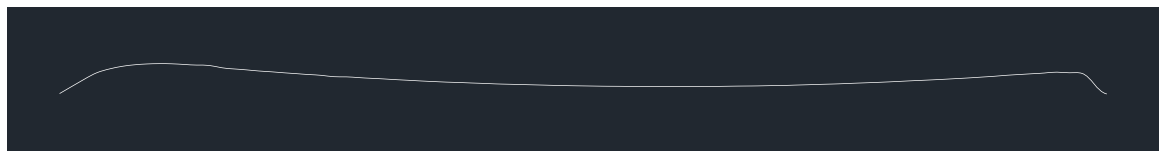

In [4]:
# Safe loading procedure (requires ezdxf v0.14):
try:
    doc, auditor = recover.readfile('test.dxf')
except IOError:
    print(f'Not a DXF file or a generic I/O error.')
    sys.exit(1)
except ezdxf.DXFStructureError:
    print(f'Invalid or corrupted DXF file.')
    sys.exit(2)

# The auditor.errors attribute stores severe errors,
# which may raise exceptions when rendering.
if not auditor.has_errors:
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ctx = RenderContext(doc)
    out = MatplotlibBackend(ax)
    Frontend(ctx, out).draw_layout(doc.modelspace(), finalize=True)
    #fig.savefig('your.png', dpi=300)

8400